# **Entendendo o negócio**

**Sobre os dados:** Esses dados apresentam informações sobre pessoas que buscaram um cartão de crédito. Nele temos diversos tipos de dados como categórico binário, quantitativo discreto, quantitativo contínuo e categórico nominal.

**Objetivo:** Fazer a previsão de quais pessoas conseguem aprovação do cartão de crédito e a retirada de possíveis ações para busca de mais candidatos.

**Fluxo do projeto:**
- Entendendo o negócio
- Entendendo os dados
- Análise da distribuição dos dados
- Pré-processamento
- Modelagem
  - Comparação dos modelos e escolha do que possui melhor desempenho
  - Ajustando o modelo com hiper-parâmetros
- Avaliação
  - Avaliar o modelo com as métricas
- Resultados Financeiros

.

**Dataset:** https://www.kaggle.com/datasets/samuelcortinhas/credit-card-approval-clean-data?resource=download

# **Entendendo os dados**

Importação das bibliotecas que serão utilizadas ao decorrer do projeto.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, brier_score_loss, roc_curve, precision_recall_curve, auc, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

Definindo algumas configurações globais para os gráficos.

In [1]:
#%matplotlib inline

#mpl.style.use('ggplot')

#mpl.rcParams['axes.facecolor']      = 'white'
#mpl.rcParams['axes.linewidth']      = 1
#mpl.rcParams['xtick.color']         = 'black'
#mpl.rcParams['ytick.color']         = 'black'
#mpl.rcParams['grid.color']          = 'lightgray'
#mpl.rcParams['figure.dpi']          = 100
#mpl.rcParams['axes.grid']           = True
#mpl.rcParams['font.size']           = 12

Importação dos dados que iremos utilizar.

In [4]:
dados = 'Dados/clean_dataset.csv'
df = pd.read_csv(dados)

In [5]:
df.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,0,ByOtherMeans,120,0,1


### **Dicionário dos dados:**
- **Gender:** Gênero do cliente, 0 = mulher e 1 = homem. Categórico binário.
- **Age:** Idade do cliente. Quantitativo discreto.
- **Debt:** Valor da dívida atual do cliente. Quantitativo contínuo.
- **Married:** Estado civil, 0 = Solteiro/Divorciado/etc, 1 = Casado. Categórico binário.
- **BankCustomer:** Indica se ele é um cliente bancário, 1 = tem uma conta bancária, 0 = não tem um conta. Categórico binário.
- **Industry:** Setor do emprego do cliente. Categorica Nominal.
- **Ethnicity:** Grupo étnico na qual o cliente pertence. Categórico binário.
- **YearsEmployed:** Quantidade de anos que o cliente esta empregado. Quantitativo discreto.
- **PriorDefault:** Histórico de inadimplência em pagamentos anteriores. 0 = incumprimento anterior, 1 = cumprimento anterior. Categórico binário.
- **Employed:** Status de emprego atual do cliente. 1 = empregado, 0 = desempregado. Categórico binário.
- **CreditScore:** Pontução de crédito. Quantitativo discreto.
- **DriversLicense:** Indica se o cliente possui uma carteira de motorista válida. 1 = possui carteira, 0 = não possui carteira. Categórico binário.
- **Citizen:**  Status de cidadania. Categórica nominal.
- **ZipCode:** Código postal da residencia. Categórico nominal.
- **Income:** Renda anual do cliente. Quantitativo contínuo.
- **Approved:** Status de aprovação para o cartão de crédito, 1 = aprovado, 0 = não aprovado. Categórico binário.

In [6]:
print(f'O DataFrame possui {df.shape[0]} linhas e {df.shape[1]} colunas')

O DataFrame possui 690 linhas e 16 colunas


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          690 non-null    int64  
 1   Age             690 non-null    float64
 2   Debt            690 non-null    float64
 3   Married         690 non-null    int64  
 4   BankCustomer    690 non-null    int64  
 5   Industry        690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    int64  
 9   Employed        690 non-null    int64  
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    int64  
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    int64  
 14  Income          690 non-null    int64  
 15  Approved        690 non-null    int64  
dtypes: float64(3), int64(10), object(3)
memory usage: 86.4+ KB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,690.0,0.695652,0.460464,0.00,0.000,1.00,1.0000,1.00
Age,690.0,31.514116,11.860245,13.75,22.670,28.46,37.7075,80.25
Debt,690.0,4.758725,4.978163,0.00,1.000,2.75,7.2075,28.00
Married,690.0,0.760870,0.426862,0.00,1.000,1.00,1.0000,1.00
BankCustomer,690.0,0.763768,0.425074,0.00,1.000,1.00,1.0000,1.00
YearsEmployed,690.0,2.223406,3.346513,0.00,0.165,1.00,2.6250,28.50
PriorDefault,690.0,0.523188,0.499824,0.00,0.000,1.00,1.0000,1.00
Employed,690.0,0.427536,0.495080,0.00,0.000,0.00,1.0000,1.00
CreditScore,690.0,2.400000,4.862940,0.00,0.000,0.00,3.0000,67.00
DriversLicense,690.0,0.457971,0.498592,0.00,0.000,0.00,1.0000,1.00


- É possível visualizar que a maioria dos dados se refere ao gênero masculino.
- Na idade mostra uma grande variedade, sendo de adolecentes de 13 anos até idosos de 80. Porém boa parte das pessoas possuem entre 22 e 37 anos.
- Nas dívidas percebemos que a médiana esta em 2.75 e o valor máximo é 28. Isso mostra que boa parte das pessoas possuem dividas baixas.
- A maioria dos indivíduos são casados.
- Uma grande parte já são clientes regulares de banco.
- Nos anos empregrados concluímos com base nos quartis que muitos estão em empregos recentes.
- Um pouco mais da média não teve inadinplencia anterior.
- Há uma proporção negativa, levando em consideração a quantidade de pessoas que não estão empregadas.
- Levando em consideração a escala de crédito na qual inicia em 0 e seu máximo é 67, boa parte das pessoas possuem créditos baixos.
- Menos da metade das pessoas possuem carteira de habilitação.
- Há uma grande desigualdade nas rendas, tendo um desvio padrão de 5210, enquanto a média de salários fica em 1017 o máximo registrado é de 100.000.
- Apenas cerca de 44% dos participantes foram aprovados.

In [9]:
numericos_com_bool = df.select_dtypes('number').columns.tolist()
numericos = [col for col in numericos_com_bool if df[col].nunique() > 2]
booleanos = [col for col in numericos_com_bool if df[col].nunique() < 3]
categoricos = df.select_dtypes('object').columns.tolist()
objetivo = 'Approved'

print(f"Há {len(numericos)} dados numéricos, sendo eles:")
print(numericos)
print(f"\nHá {len(booleanos)} dados booleanos, sendo eles:")
print(booleanos)
print(f"\nHá {len(categoricos)} dados categóricos, sendo eles:")
print(categoricos)
print(f"\nVariável alvo:")
print(objetivo)

Há 6 dados numéricos, sendo eles:
['Age', 'Debt', 'YearsEmployed', 'CreditScore', 'ZipCode', 'Income']

Há 7 dados booleanos, sendo eles:
['Gender', 'Married', 'BankCustomer', 'PriorDefault', 'Employed', 'DriversLicense', 'Approved']

Há 3 dados categóricos, sendo eles:
['Industry', 'Ethnicity', 'Citizen']

Variável alvo:
Approved


In [10]:
for elemento in categoricos:
  print(elemento)
  print('-'*40)
  print(f'Há {df[elemento].nunique()} valores únicos, sendo eles:')
  print(f'{df[elemento].value_counts(normalize=True)}\n')

Industry
----------------------------------------
Há 14 valores únicos, sendo eles:
Industry
Energy                   0.211594
Materials                0.113043
Industrials              0.092754
ConsumerDiscretionary    0.085507
ConsumerStaples          0.078261
Healthcare               0.076812
Financials               0.073913
InformationTechnology    0.059420
CommunicationServices    0.055072
Utilities                0.055072
Real Estate              0.043478
Education                0.036232
Research                 0.014493
Transport                0.004348
Name: proportion, dtype: float64

Ethnicity
----------------------------------------
Há 5 valores únicos, sendo eles:
Ethnicity
White     0.591304
Black     0.200000
Asian     0.085507
Latino    0.082609
Other     0.040580
Name: proportion, dtype: float64

Citizen
----------------------------------------
Há 3 valores únicos, sendo eles:
Citizen
ByBirth         0.905797
ByOtherMeans    0.082609
Temporary       0.011594
Name: pro

## **Análise da distribuição dos dados**
Iremos fazer uma análise de cada um dos dados separadamente para compreendermos como é sua distribuição.

Abaixo estaremos observando como esta o balanceamento da nossa variável alvo.

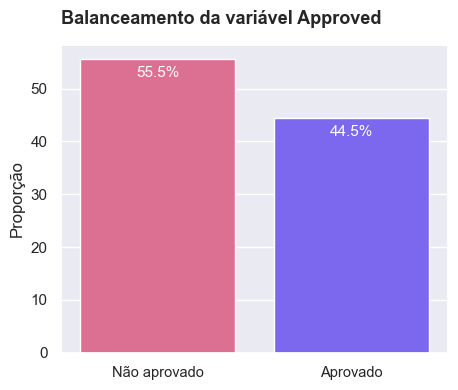

In [11]:
approved = df['Approved'].value_counts(normalize=True)
approved_df = approved.reset_index()
approved_df.columns = ['Approved', 'Proportion']
approved_df['Proportion'] = approved_df['Proportion'].apply(lambda x: x * 100)

sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(5, 4))
bars = sns.barplot(data=approved_df, x='Approved', y='Proportion', ax=ax)
ax.set_xticks(ticks=range(2), labels=['Não aprovado', 'Aprovado'], fontsize=10.5)
ax.set_ylabel('Proporção')
ax.set_xlabel('')
ax.set_title('Balanceamento da variável Approved', fontsize=13, fontweight='bold', pad=15, loc='left')

colors = ['#DB7093', '#7B68EE']
for i, bar in enumerate(ax.patches):
  bar.set_facecolor(colors[i])

for bar in bars.containers[0]:
  height = bar.get_height()
  ax.annotate('{:.1f}%'.format(height),
              xy=(bar.get_x() + bar.get_width() / 2, height),
              xytext=(0, -10),
              textcoords="offset points",
              ha='center', va='center',
              fontsize=11, color='white')

plt.show()

Os dados não estão completamente desbalanceados, mas existe uma leve predominancia dos não aprovados. Nesse caso temos um balanceamento moderado e aceitável.

analisar a possibilidade de aplicar técnicas para aumentar a classe de aprovados. Oversampling: SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica comum.

### **Distribuição numérica**

Abaixo temos gráficos histogramas que apresetam a distribuição dos dados das colunas numéricas.

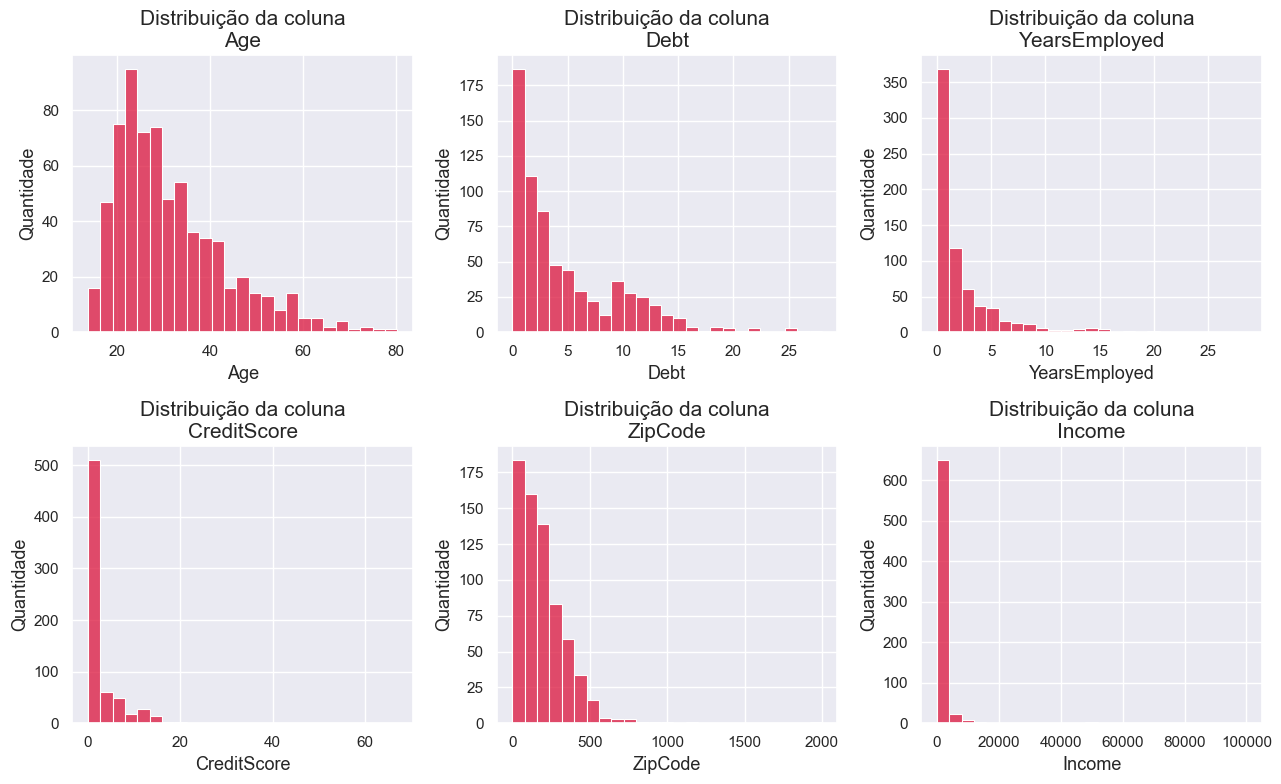

In [12]:

num_plots = len(numericos)
rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)

fig, ax = plt.subplots(rows, 3, figsize=(13, 4 * rows))
ax = ax.flatten()

for i, coluna in enumerate(numericos):
    sns.histplot(data=df, x=coluna, ax=ax[i], bins=25, color='#DC143C')
    ax[i].set_title(f'Distribuição da coluna\n{coluna}', fontsize=15)
    ax[i].set_xlabel(coluna, fontsize=13)
    ax[i].set_ylabel('Quantidade', fontsize=13)

for i in range(len(numericos), len(ax)):
    fig.delaxes(ax[i])

plt.tight_layout()
plt.show()

Abaixo estamos apenas dando um zoom, definindo os limites para focar na parte densa dos dados para melhor visualização.

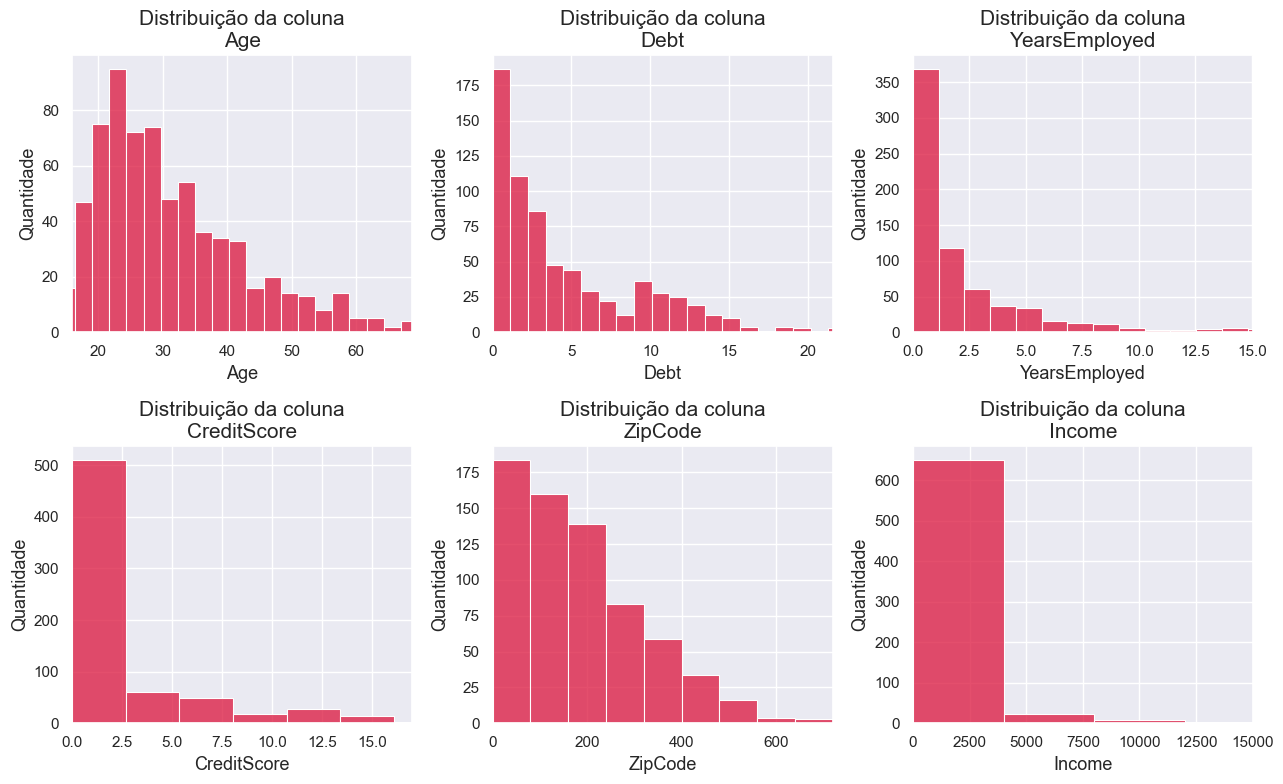

In [13]:
num_plots = len(numericos)
rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)
fig, ax = plt.subplots(2, 3, figsize=(13, 4 * rows))
ax = ax.flatten()

for i, coluna in enumerate(numericos):
    sns.histplot(data=df, x=coluna, ax=ax[i], bins=25, color='#DC143C')
    ax[i].set_title(f'Distribuição da coluna\n{coluna}', fontsize=15)
    ax[i].set_xlabel(coluna, fontsize=13)
    ax[i].set_ylabel('Quantidade', fontsize=13)

    ax[i].set_xlim(df[coluna].quantile(0.01), df[coluna].quantile(0.99))

plt.tight_layout()
plt.show()

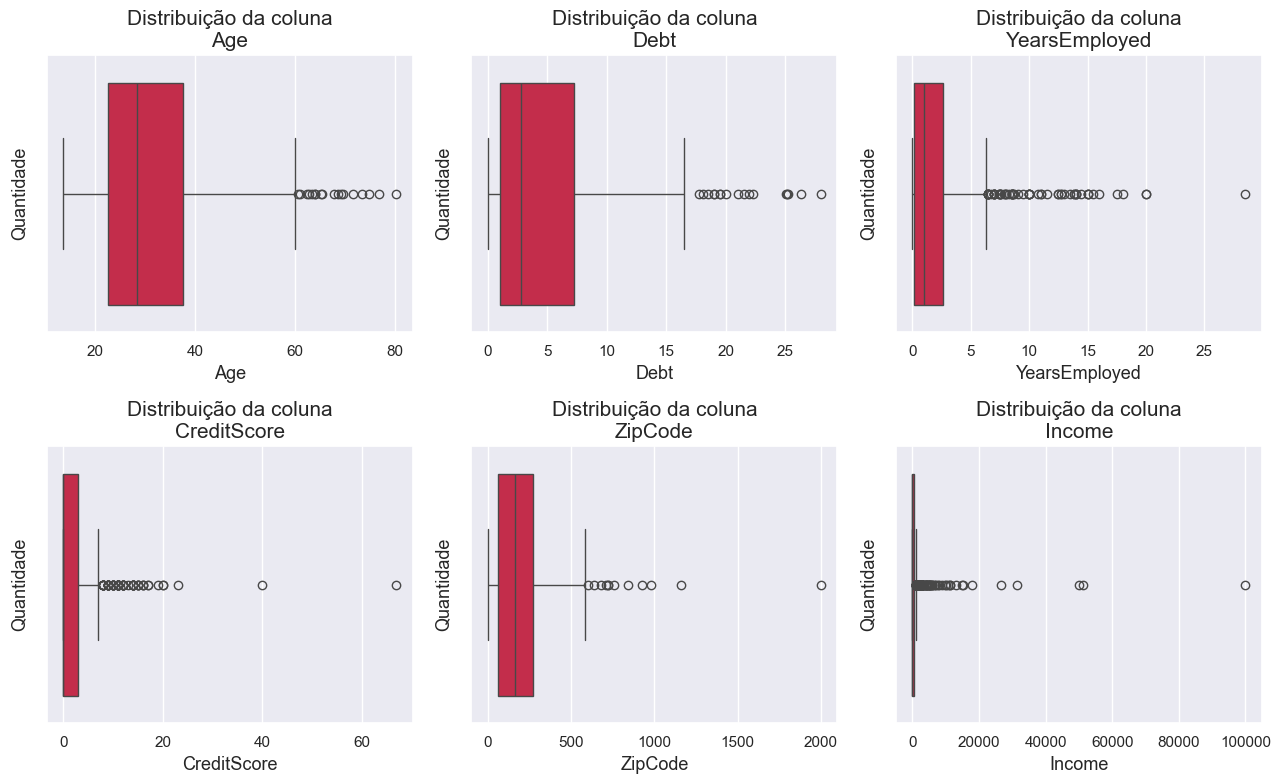

In [14]:
num_plots = len(numericos)
rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)

fig, ax = plt.subplots(rows, 3, figsize=(13, 4 * rows))
ax = ax.flatten()

for i, coluna in enumerate(numericos):
    sns.boxplot(data=df, x=coluna, ax=ax[i], color='#DC143C')
    ax[i].set_title(f'Distribuição da coluna\n{coluna}', fontsize=15)
    ax[i].set_xlabel(coluna, fontsize=13)
    ax[i].set_ylabel('Quantidade', fontsize=13)

for i in range(len(numericos), len(ax)):
    fig.delaxes(ax[i])

plt.tight_layout()
plt.show()

### **Observações das distribuições dos dados numéricos.**
- A maioria dos indivíduos estão na faixa de 20 a 60 anos de idade com uma mediana abaixo de 40 anos mostrando uma faixa de idade jovem. Também mostrando um pico significativo na faixa dos 20 ao 30 anos.
- A distribuição dos valores da dívida é assimétrica mostrando uma grande quantidade de valores baixos.
- A maioria das pessoas esta empregada por menos de 5 anos, reforçando que a maioria são pessoas jovens que estão iniciando a carreira.
- Com a maioria dos indicadores de crédito baixo, podem ajudar a explicar as dívidas elevadas e a concentração na baixa renda.

### **Distribuição categórica**

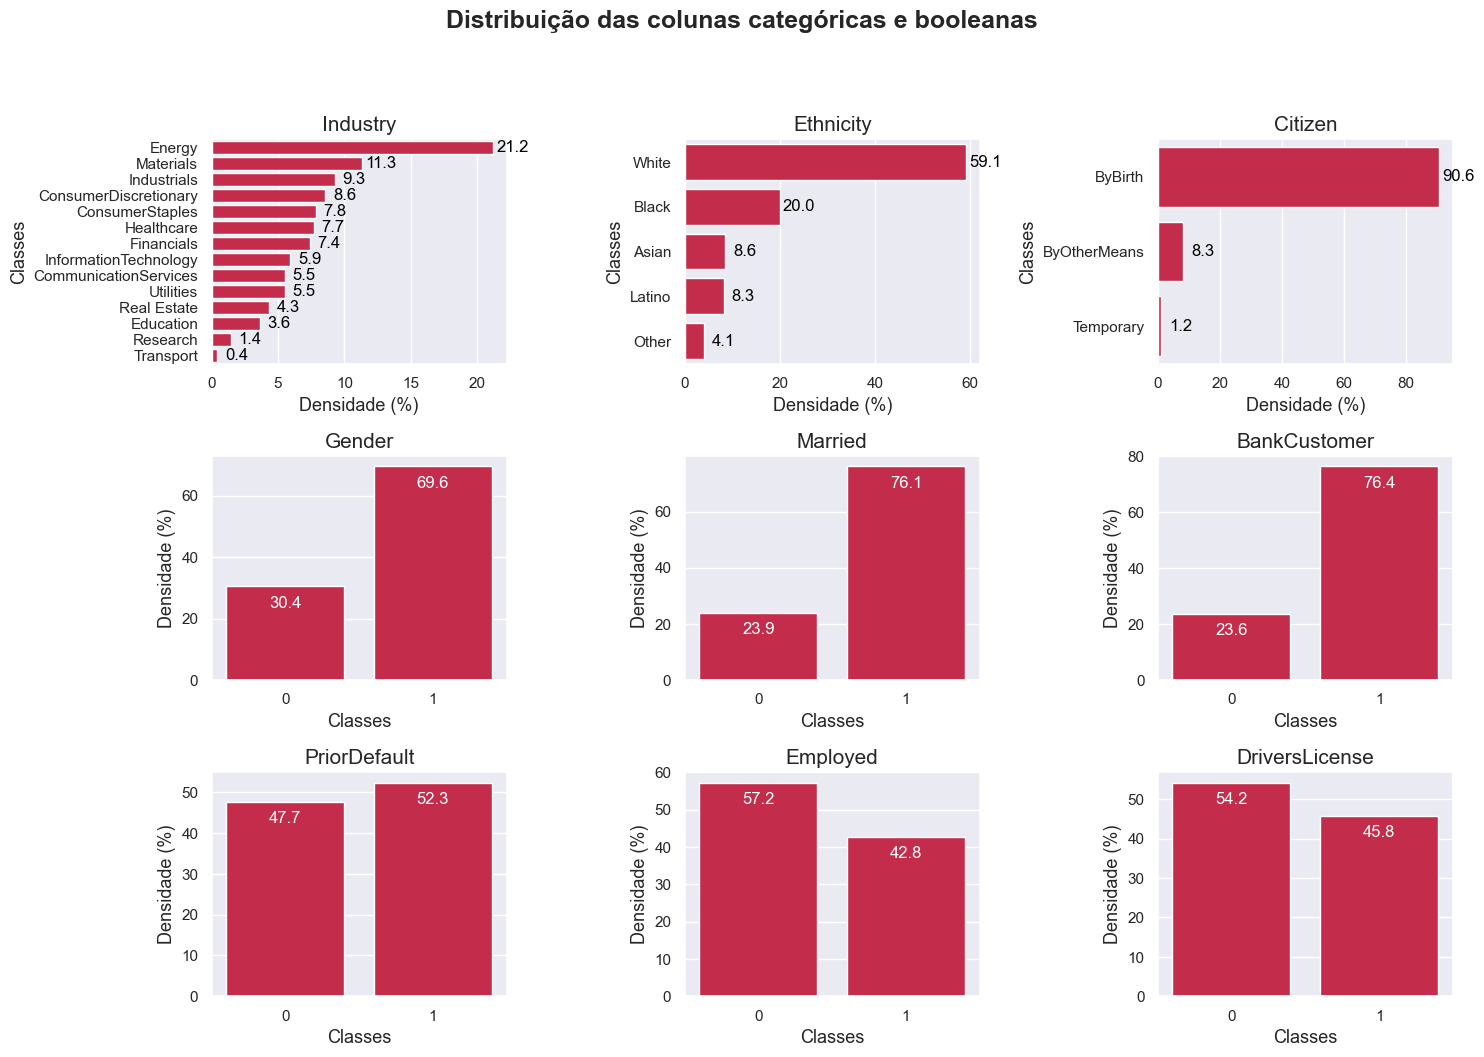

In [15]:

if 'Approved' in booleanos:
    booleanos.remove('Approved')

num_plots = len(categoricos) + len(booleanos)
dist = list(categoricos) + list(booleanos)
rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)

fig, ax = plt.subplots(rows, 3, figsize=(15, 3.5 * rows))
ax = ax.flatten()
fig.suptitle('Distribuição das colunas categóricas e booleanas', fontsize=18, y=1.005, fontweight='bold')
plt.subplots_adjust(hspace=0.6, wspace=0.4)

for i, coluna in enumerate(categoricos):
    counts = df[coluna].value_counts(normalize=True) * 100
    sns.barplot(y=counts.index, x=counts.values, ax=ax[i], color='#DC143C')
    ax[i].set_title(coluna, fontsize=15)
    ax[i].set_ylabel('Classes', fontsize=13)
    ax[i].set_xlabel('Densidade (%)', fontsize=13)
    for p in ax[i].patches:
        ax[i].annotate(format(p.get_width(), '.1f'),
                       (p.get_width(), p.get_y() + p.get_height() / 2.),
                       ha='center', va='center',
                       xytext=(14, 0),
                       textcoords='offset points',
                       color='black')

for i, coluna in enumerate(booleanos):
    counts = df[coluna].value_counts(normalize=True) * 100
    sns.barplot(x=counts.index, y=counts.values, ax=ax[i + len(categoricos)], color='#DC143C')
    ax[i + len(categoricos)].set_title(coluna, fontsize=15)
    ax[i + len(categoricos)].set_xlabel('Classes', fontsize=13)
    ax[i + len(categoricos)].set_ylabel('Densidade (%)', fontsize=13)
    for p in ax[i + len(categoricos)].patches:
        ax[i + len(categoricos)].annotate(format(p.get_height(), '.1f'),
                                          (p.get_x() + p.get_width() / 2., p.get_height()),
                                          ha='center', va='center',
                                          xytext=(0, -12),
                                          textcoords='offset points',
                                          color='white')

# Remover subplots vazios, caso tiver
for i in range(len(dist), len(ax)):
    fig.delaxes(ax[i])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### **Observações das distribuições dos dados categóricos.**

- A maioria das pessoas trabalham em uma industria de energia, materiais e industrias.
- Boa parte das pessoas se identificam com a etnica branca.
- Com uma grande concentração de 90% os status de cidadania é por nascimento.
- A distribuição de gênero tem uma predominancia de homens.
- Grande parte já são casados, talvez indicando uma estabilidade financeira.
- Uma certa quantidade já são clientes de um banco, sendo positivo para entendermos melhor a situação fiananceira.
- Há um certo equilibrio entre as pessoas que possuem e as que não possuem inadimplencia.
- A maioria das pessoas estão empregadas, o que apresenta uma certa estabilidade de renda.

### **Correlação dos dados**

Primeiro iremos fazer a conversão das variáveis categóricas para as numéricas.

In [16]:
label_encoder = LabelEncoder()
df_com_le = df.copy()

for coluna in categoricos:
    df_com_le[coluna] = label_encoder.fit_transform(df[coluna])

Para fazer a matriz de correlação iremos utilizar o método de Spearman, pois ela não é eficaz somente para relações lineares sendo útil quando estamos lidando com variáveis categóricas e contínuas. Com ela temos uma menor sensibilidade dos outliers em comparação ao Pearson.

Estarei usando como base que correlações com valores acima de 0.5 são fortes, de 0.3 a 0.5 são moderadas.

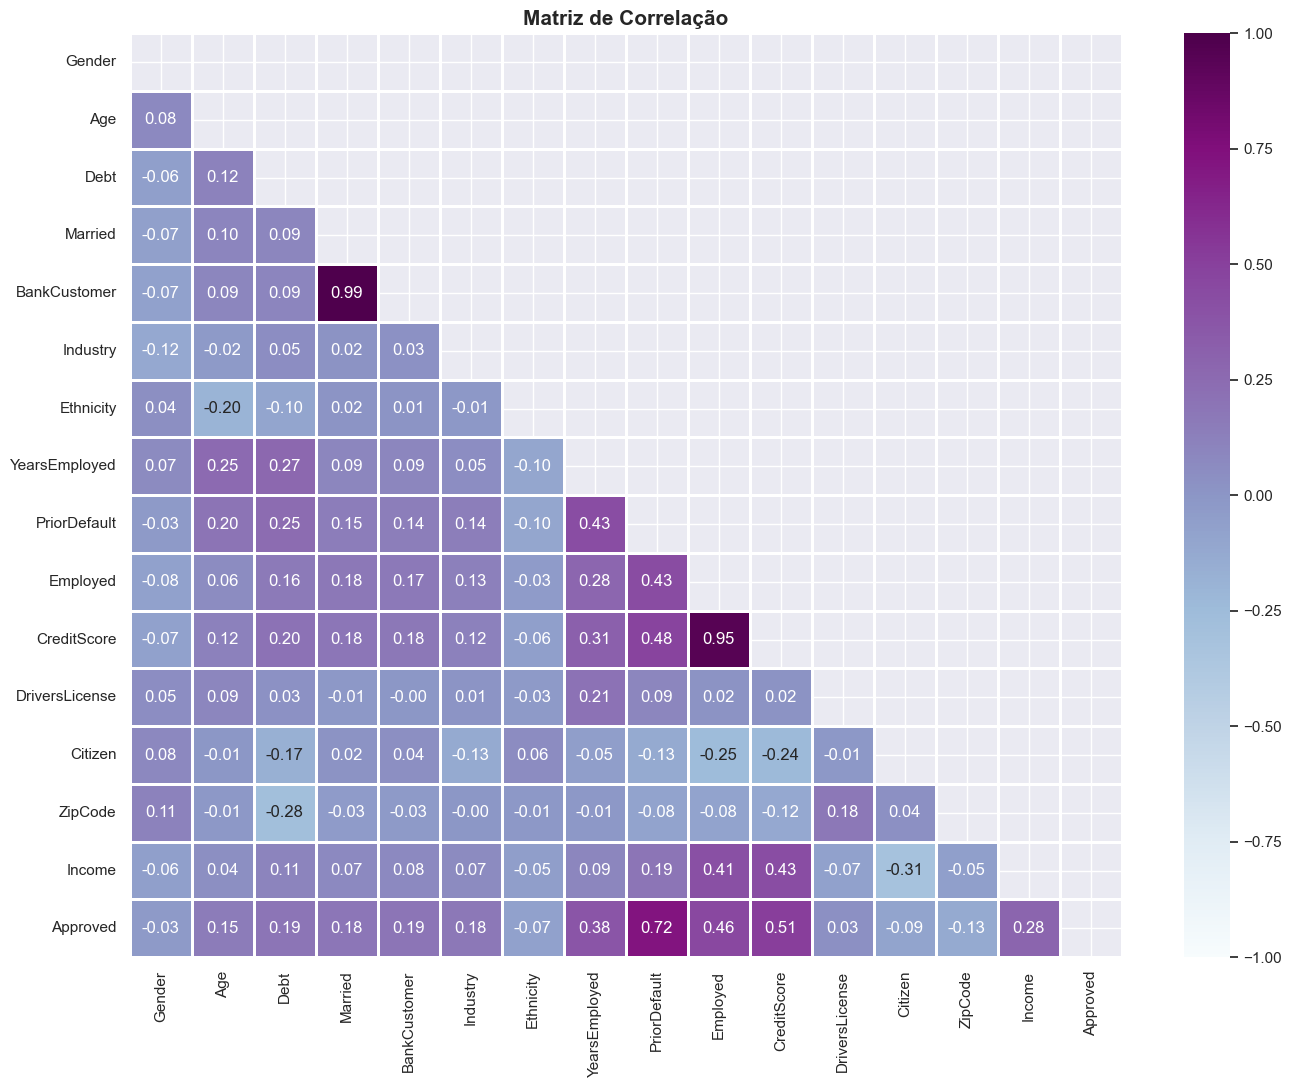

In [17]:
correlacao = df_com_le.corr(numeric_only=True, method='spearman')
mascara = np.triu(np.ones_like(correlacao, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(correlacao, mask=mascara, annot=True, cmap='BuPu', fmt='.2f', linewidths=1, vmin=-1, vmax=1)
plt.title('Matriz de Correlação', fontsize=15, fontweight='bold')
plt.show()

- Diretamente em relação a variável alvo (Approved), podemos ver que uma forte influencia é o PriorDefault (Inadimplência) com 0.72, indicando que caso a pessoa já tiver um histórico de inadimplência ela é menos favoravel para receber a aprovação.
- Outro influenciador principal é a prontuação de crédito, assim como o status de emprego atual do indivíduo e a quantidade de anos que a pessoa esta empregada.
- A pontuação de crédito é influenciada principalmente pelo status de emprego e se a pessoa já teve casos de inadimplencia.
- Podemos perceber que boa parte das pessoas com inadimplência são influenciada por pessoas empregadas.


### **Observando como a aprovação esta distribuida nos setores de trabalho**

Com isso podemos observar em qual setor temos mais aprovações, o que pode nos trazer ações futuras para incentivo nessas áreas.

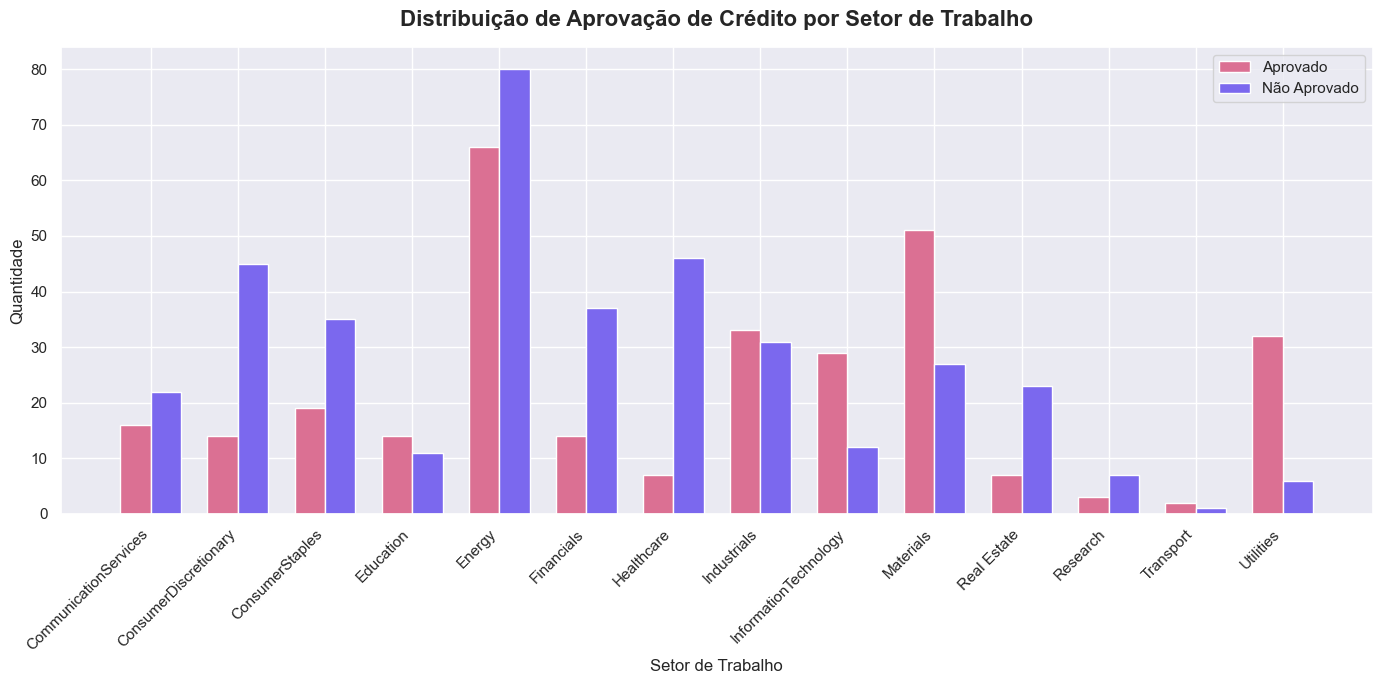

In [18]:
approval_counts = df.groupby(['Industry', 'Approved']).size().unstack(fill_value=0)

approval_counts.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(14, 7))
bar_width = 0.35
bar_positions = np.arange(len(approval_counts))

bars_approved = ax.bar(bar_positions, approval_counts[1], bar_width, label='Aprovado', color=colors[0])
bars_not_approved = ax.bar(bar_positions + bar_width, approval_counts[0], bar_width, label='Não Aprovado', color=colors[1])

ax.set_xlabel('Setor de Trabalho')
ax.set_ylabel('Quantidade')
ax.set_title('Distribuição de Aprovação de Crédito por Setor de Trabalho', fontsize=16, pad=15, fontweight='bold')
ax.set_xticks(bar_positions + bar_width / 2)
ax.set_xticklabels(approval_counts['Industry'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

### **Principais observações**

- A maioria dos indivíduos que estão buscando crédito são jovens que estão no inicio da carreia profissional, o que também da sentido aos valores baixos de renda. Com isso apresenta a possibilidade da instituição financeira desenvolver produtos de crédito especifico para jovens profissionais, com possibilidades de juros mais baixo e ofertas que ajudem no inicio de carreira.
- A maioria da amostra é composta por cidadãos natos e com emprego, possivelmente em setores específicos, e por isso poderiam ser concentradas as campanhas de marketing em áreas com forte empregabilidade, como por exemplo o setor de energia e materiais.
- A predominancia de clientes bancários sugere uma oportunidade de estratégias para inclusão financeira. Uma parceria e programas que visem a minoria e grupos que possuem menos acesso a serviços bancários, com imprestimos mais favorais a essas pessoas.
- A pontuação de crédito é influenciada pelo status de emprego atual e pela sua duração, e incluindo programas de transição de carreita pode beneficiar a instituição para aumentar a base de clientes com melhor capacidade de pagamento.
- Com a alta inadimplencia observada, é interessante realizar uma análise para identificar os sinais precoces de inadimplência.

# **Pré-processamento dos dados**

### **Sepração dos dados em treinamento e teste**

- Essa sepração serve para que os dados de teste do modelo não tenha sido visto anteriormente, fazendo com que tenhamos mais certeza que a avaliação é justa e precisa.
- Com isso também também fazemos uma prevensão de overfitting, evitando que o modelo se ajuste aos dados apresentados e generalise os novos.
- Será usado o 'stratify' para que os dados de treinamento e teste mantenham a mesma proporção da variável alvo, pois sem a estratificação é possivel que uma das classes fique subrepresentada no conjunto de teste ou treinamento.
- Como os dados possui um breve desbalanceamento, resolvi utilizar o SMOTE para conseguir mais dados com base nos já existentes, levando em consideração que a temos uma quantidade relativamente baixa para uma boa precisão.

In [19]:
scaler = MinMaxScaler()
df_com_le[numericos + categoricos] = scaler.fit_transform(df_com_le[numericos + categoricos])

X = df_com_le.drop('Approved', axis=1)
y = df_com_le['Approved'].copy()

In [20]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Dados antes do SMOTE:", X.shape)
print("Dados após o SMOTE:", X_resampled.shape)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

Dados antes do SMOTE: (690, 15)
Dados após o SMOTE: (766, 15)


Com o objetivo de verificar se os dados foram separados corretamente mantendo a distribuição, estarei verificando o shape das variáveis.

In [21]:
print(f'X train: {X_train.shape}.')
print(f'y train: {y_train.shape}.')
print(f'X test: {X_test.shape}.')
print(f'y train: {y_test.shape}.')

X train: (612, 15).
y train: (612,).
X test: (154, 15).
y train: (154,).


**Estaremos Utilizando os seguintes modelos:**

- Regressão logística: Simples de interpretar e implementar.
- Árvore de decisão: Fácil de interpretar e não requer normalização dos dados e é bom para detectar relações não lineares.
- Random forest: Reduz a probabilidade de overfitting, lida bem com dados categóricos e numéricos.

**Também utilizaremos as seguintes métricas de avaliação:**

- Acurácia: Ela mede a proporção de previsões corretas tantos positivas quanto negativas.
- F1: É uma média harmônica entre precisão e recall, balanceando a necessidade de ambos.

# **Treinamento para comparação dos modelos**

Abaixo estaremos fazendo um treinamento simples usando a validação cruzada para a visualização da avaliação de cada modelo, com isso será escolhido um deles para o aprimoramento aplicando hiperparâmetros.

In [22]:
tree_models = {
    'Regressão Logística': LogisticRegression(class_weight='balanced', random_state=30),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=30),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=30)
}

Abaixo estamos criando uma função para o treinamento com a validação cruzada, como iremos fazer o processo com alguns modelos, dessa forma fica mais fácil de compreender.

In [23]:
from sklearn.model_selection import cross_val_predict

def classification_kfold_cv(models, X_train, y_train, n_folds=5):
    results = []
    cf = []
    for model_name, model in models.items():

        y_pred = cross_val_predict(model, X_train, y_train, cv=n_folds)
        conf_matriz = confusion_matrix(y_train, y_pred)
        cf.append({'model': model_name,
                   'c_report':classification_report(y_train, y_pred)})

        scores = cross_val_score(model, X_train, y_train, cv=n_folds, scoring='accuracy')

        results.append({
            'model': model_name,
            'avg_val_score': scores.mean(),
            'conf_matriz' : conf_matriz,
        })
    return pd.DataFrame(results), cf




Abaixo estamos criando uma função para a plotagem do gráfico de comparação dos modelos treinados.

In [26]:
def plot_classification_kfold_cv(df, bar_width=0.35, figsize=(7, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50):
    fig, ax = plt.subplots(figsize=figsize)
    bars = sns.barplot(data= df, x='model', y='avg_val_score', width=bar_width, color=colors[1])
    ax.set_title('Comparação dos modelos', fontsize=title_size, pad=title_pad, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_xlabel('Model')
    plt.xticks(rotation=45)

    for bar in bars.containers[0]:
      height = bar.get_height()
      ax.annotate('{:.3f}%'.format(height),
              xy=(bar.get_x() + bar.get_width() / 2, height),
              xytext=(0, -10),
              textcoords="offset points",
              ha='center', va='center',
              fontsize=11, color='white')

    plt.show()


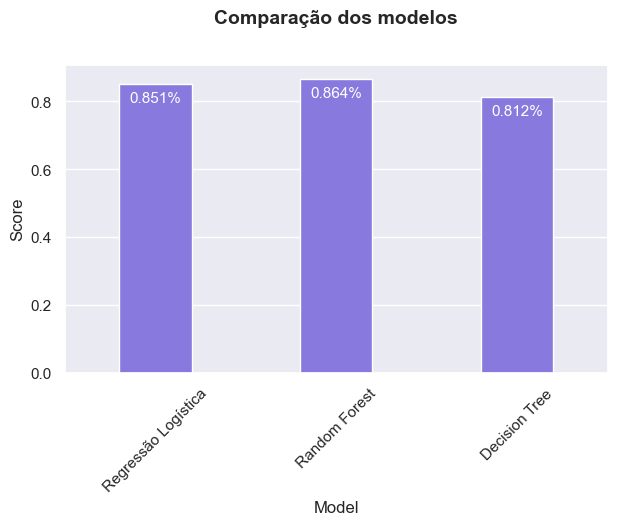

                 model  avg_val_score
0  Regressão Logística       0.851193
1        Random Forest       0.864254
2        Decision Tree       0.812009

 0    [[245, 61], [30, 276]]
1    [[264, 42], [41, 265]]
2    [[240, 66], [49, 257]]
Name: conf_matriz, dtype: object

 Regressão Logística
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       306
           1       0.82      0.90      0.86       306

    accuracy                           0.85       612
   macro avg       0.85      0.85      0.85       612
weighted avg       0.85      0.85      0.85       612


 Random Forest
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       306
           1       0.86      0.87      0.86       306

    accuracy                           0.86       612
   macro avg       0.86      0.86      0.86       612
weighted avg       0.86      0.86      0.86       612


 Decision Tree
              precisi

In [27]:
eval, cf = classification_kfold_cv(models=tree_models,
                               X_train=X_train,
                               y_train=y_train,
                               n_folds=5)

plot_classification_kfold_cv(eval, bar_width=0.4, figsize=(7, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=30)

print(eval[['model', 'avg_val_score']])
mc = eval['conf_matriz']
print('\n',mc)
for i in cf:
  print('\n',i['model'])
  print(i['c_report'])

    Modelo                  avg_val_score     f1-score

    Regressão Logística     85,11%            0.84
    Random Forest           86,26%            0.86
    Decision Tree           81,20%            0.81

Visualizando as métricas que foram avaliadas dos modelos, irei escolher o Random Forest por ter um equilibrio e um valor maior na acurácia e no f1.

# **Ajustando os hiperparâmetros do modelo escolhido**



Agora iremos ajustar os hiperparâmetros com o objetivo de otimizar o modelo e maximizar seu potencial, além disso conseguimos uma prevenção de overfitting e underfitting, sendo importante levando em consideração que anteriormente a pontuação de treino deu 1, indicando um possível overfitting. Ajustar o modelo melhora o tempo e os recursos adicionais.

Abaixo estou utilizando o optuna que é uma ferramenta de otimização de hiperparâmetros, com o objetivo de encontrar os melhores parâmetros de forma eficiênte, economizando tempo.

In [28]:
def objective_random_forest(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 16),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 16),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.1)
    }

    model = RandomForestClassifier(**params)
    stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    val_scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=stratified_kfold)
    avg_f1_score = np.mean(val_scores)
    return avg_f1_score

study_random_forest = optuna.create_study(direction='maximize')

study_random_forest.optimize(objective_random_forest, n_trials=100)

best_params_random_forest = study_random_forest.best_params
best_score_random_forest = study_random_forest.best_value

print("Random Forest - Melhores Hiperparâmetros:", best_params_random_forest)
print("Random Forest - Melhor F1 Score:", best_score_random_forest)


[I 2025-01-17 18:01:51,693] A new study created in memory with name: no-name-5d9b7088-3312-4794-a8cd-6d811ffa84da
[I 2025-01-17 18:01:52,962] Trial 0 finished with value: 0.8633923112232939 and parameters: {'n_estimators': 126, 'max_depth': 2, 'min_samples_split': 13, 'min_samples_leaf': 6, 'bootstrap': True, 'max_features': 'log2', 'criterion': 'gini', 'min_impurity_decrease': 0.05123415540010171}. Best is trial 0 with value: 0.8633923112232939.
[I 2025-01-17 18:01:53,945] Trial 1 finished with value: 0.8651745497825202 and parameters: {'n_estimators': 77, 'max_depth': 2, 'min_samples_split': 16, 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': None, 'criterion': 'entropy', 'min_impurity_decrease': 0.015466671421809975}. Best is trial 1 with value: 0.8651745497825202.
[I 2025-01-17 18:01:56,055] Trial 2 finished with value: 0.8679007983431843 and parameters: {'n_estimators': 229, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 3, 'bootstrap': False, 'max_features

Random Forest - Melhores Hiperparâmetros: {'n_estimators': 376, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 14, 'bootstrap': True, 'max_features': None, 'criterion': 'entropy', 'min_impurity_decrease': 0.016062275684407133}
Random Forest - Melhor F1 Score: 0.8803587205804947


### **Ajustando o modelo com os melhores parametros**



Abaixo temos os melhores parâmetros capturados no processo anterior.

In [29]:
melhores_parametros = {'n_estimators': 332,
                       'max_depth': 12,
                       'min_samples_split': 10,
                       'min_samples_leaf': 10,
                       'bootstrap': True,
                       'max_features': None,
                       'criterion': 'entropy',
                       'min_impurity_decrease': 0.01550720051004077}

E finalmente iremos fazer o treinamento. Aqui estamos utilizando os parametros escolhidos anteriormente, utilizamos o random_state para garantir a reprodutibilidade dos dados.

In [30]:
rf_clf = RandomForestClassifier(**melhores_parametros, random_state=42)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=12, max_features=None,
                       min_impurity_decrease=0.01550720051004077,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=332, random_state=42)

In [31]:
y_pred_rf = rf_clf.predict(X_test)

print("Random Forest - Relatório de Classificação (Conjunto de Teste):")
print(classification_report(y_test, y_pred_rf))

print("Random Forest - Matriz de Confusão (Conjunto de Teste):")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest - Relatório de Classificação (Conjunto de Teste):
              precision    recall  f1-score   support

           0       0.87      0.88      0.88        77
           1       0.88      0.87      0.88        77

    accuracy                           0.88       154
   macro avg       0.88      0.88      0.88       154
weighted avg       0.88      0.88      0.88       154

Random Forest - Matriz de Confusão (Conjunto de Teste):
[[68  9]
 [10 67]]


Iremos observar algumas metricas do modelo, começando pela matriz de confusão.

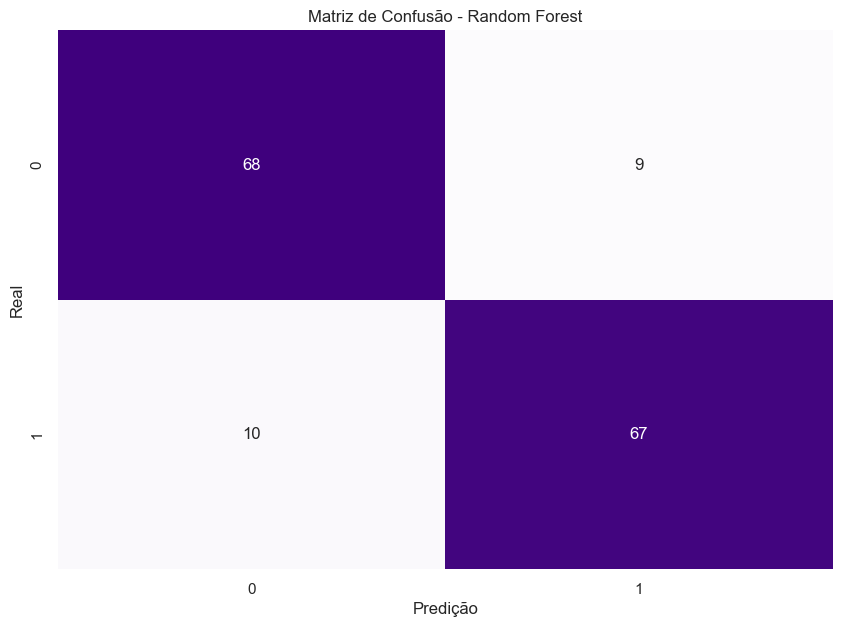

In [32]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

O desempenho geral do modelo é bom, com alta precisão e recall, significando que consegue classificar bem a maioria dos positivos quanto a maioria dos negativos.

Abaixo iremos observar a curva ROC, com ela é ilustrada a performance do modelo, plotando a taxa de verdadeiros positivos contra a taxa de falsos positivos.

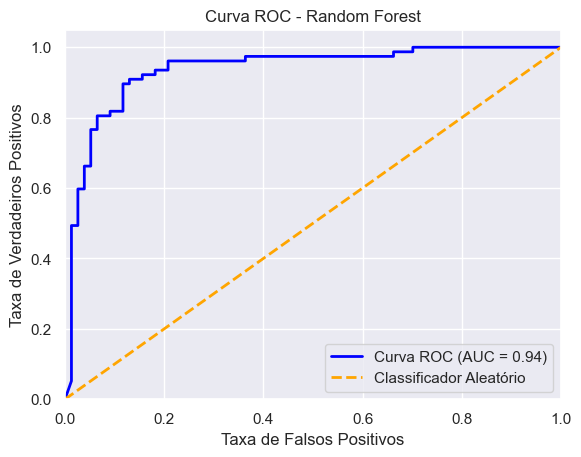

In [33]:
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--', label='Classificador Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


- O desempenho do modelo se moostra bom na classificação das categorias.
- Com um AUC de 0.94 é um boa confiança para um modelo eficaz no propósito.

In [34]:
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)
roc_auc = roc_auc_score(y_test, y_prob_rf)
brier = brier_score_loss(y_test, y_prob_rf)

fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
gini = 2 * roc_auc - 1

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob_rf)
pr_auc = auc(recall_vals, precision_vals)

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Gini', 'PR-AUC', 'Brier'],
    'Value': [accuracy, precision, recall, f1, roc_auc, gini, pr_auc, brier]
}

df_metrics = pd.DataFrame(metrics)
df_metrics


,Metric,Value
0,Accuracy,0.876623
1,Precision,0.881579
2,Recall,0.870130
3,F1-Score,0.875817
4,ROC-AUC,0.936583
5,Gini,0.873166
6,PR-AUC,0.914393
7,Brier,0.090697


- O nosso recall é de 0.87, significando que o modelo consegue identificar 87% das aprovações corretamente. Olhando para a matriz de confusão de 77 ele previu 68 corretamente.
- A precisão esta em 0.88, conseguindo identificar 88% dos dados. Observando a matriz de 77 dados ele conseguiu prever 69 corretamente.
- Com o ROC-AUC em 0.938, apresenta uma boa capacidade de diferenciar as pessoas que terão aprovação do cartão das que não terão.

## **Resultados financeiros**

Iremos analisar algumas métricas que podem ser afetadas pelas aprovações e recusas, para isso será usado como base a matriz de confusão. Com isso, iremos acompanhar algumas variáveis, sendo elas:
- Receita média por cliente aprovado (verdadeiros positivos).
- Receita dos falsos positivos (quanto de perda), pessoas que não eram para ser aprovadas.
- Receita dos falsos negativos (quanto de perda), pessoas que eram para ser aprovadas.

Importante: Os valores abaixo são fictícios.

Abaixo estaremos pegando os valores da matriz de confusão e definindo quais são os valores referentes à receita de acordo com cada situação.

In [35]:
VN, FP, FN, VP = cm.ravel()

receita_media_aprovado = 15000
custo_falsos_positivos = 2500
custo_falsos_negativos = 7500

In [36]:
receita_media_vp = VP * receita_media_aprovado

perda_fp = FP * custo_falsos_positivos

perda_fn = FN * custo_falsos_negativos

print(f"Receita Média por Cliente Aprovado (TP): R${receita_media_vp}")
print(f"Perda por Falsos Positivos (FP): R${perda_fp}")
print(f"Perda por Falsos Negativos (FN): R${perda_fn}")

Receita Média por Cliente Aprovado (TP): R$1005000
Perda por Falsos Positivos (FP): R$22500
Perda por Falsos Negativos (FN): R$75000


## **Conclusões**

- Foi feito um classificador Random Forest para fazer a previsão da aprovação do cartão de crédito. Tendo como objetivo a construção de um modelo que fosse capaz de fazer a previsão da maioria das situações, com isso, podendo analisar maneiras de aumentar o lucro e reduzir os gastos.
- O modelo é capaz de prever cerca de 87% dos casos, tendo um desempenho bem solido com a distinção das classes.
- Foi possível compreender boa parte dos dados, distribuição e correlação utilizando técnicas de EDA.
- Fazendo uma simulação com dados fictícios ainda podemos ver que consguimos uma boa quantidade de lucro em relação às perdas.